In [6]:
import asyncio
import time
import logging

import vector; vector.register_awkward()

import cabinetry
from coffea.nanoevents.schemas.base import BaseSchema, zip_forms
from coffea.nanoevents import NanoAODSchema
from coffea import processor
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents import transforms
import awkward as ak
import numpy as np
import hist
import json
import matplotlib.pyplot as plt
import uproot

import torch
import onnx

import utils

logging.getLogger("cabinetry").setLevel(logging.INFO)

In [7]:
N_FILES_MAX_PER_SAMPLE = 10
NUM_CORES = 16
CHUNKSIZE = 500_000
IO_FILE_PERCENT = 4
USE_DASK = True
AF = "coffea_casa"

In [8]:
# functions creating systematic variations
def flat_variation(ones):
    # 0.1% weight variations
    return (1.0 + np.array([0.001, -0.001], dtype=np.float32)) * ones[:, None]


def btag_weight_variation(i_jet, jet_pt):
    # weight variation depending on i-th jet pT (10% as default value, multiplied by i-th jet pT / 50 GeV)
    return 1 + np.array([0.1, -0.1]) * (ak.singletons(jet_pt[:, i_jet]) / 50).to_numpy()


def jet_pt_resolution(pt):
    # normal distribution with 5% variations, shape matches jets
    counts = ak.num(pt)
    pt_flat = ak.flatten(pt)
    resolution_variation = np.random.normal(np.ones_like(pt_flat), 0.05)
    return ak.unflatten(resolution_variation, counts)


In [9]:
def training_filter(jets, electrons, muons, genparts):
    ## filter genParticles to "matchable" particles
    # make sure parent is not None
    genpart_parent = genparts.distinctParent
    genpart_filter = np.invert(ak.is_none(genpart_parent, axis=1))
    genpart_reduced = genparts[genpart_filter]
    genpart_parent_reduced = genpart_reduced.distinctParent

    # parent must be top quark or W boson
    genpart_filter2 = ((np.abs(genpart_parent_reduced.pdgId)==6) | 
                       (np.abs(genpart_parent_reduced.pdgId)==24))
    genpart_reduced = genpart_reduced[genpart_filter2]

    # make sure particle is a quark
    genpart_filter3 = ((np.abs(genpart_reduced.pdgId)<9) & 
                       (np.abs(genpart_reduced.pdgId)>0))
    genpart_reduced = genpart_reduced[genpart_filter3]

    # get rid of copies
    genpart_filter4 = genpart_reduced.hasFlags("isLastCopy")
    genpart_reduced = genpart_reduced[genpart_filter4]
            
    # get labels
    nearest_genpart = jets.nearest(genpart_reduced, threshold=0.4)
            
    labels = nearest_genpart.distinctParent.pdgId
    
    # edit labels
    counts = ak.num(labels)
    labels_flat = np.abs(ak.flatten(labels).to_numpy())
    labels_flat[(labels_flat!=6)&(labels_flat!=24)]=0 # other
    labels_flat[(labels_flat==6)]=1 # top quark
    labels_flat[(labels_flat==24)]=2 # W boson
    labels = ak.unflatten(labels_flat, counts)
    labels = ak.fill_none(labels,0)
            
    # make sure events have 2 W jets and 2 t jets
    jet_truth_filter = ((ak.sum(labels==1, axis=-1)==2) & 
                        (ak.sum(labels==2, axis=-1)==2))
            
    # filter events
    jets = jets[jet_truth_filter]
    electrons = electrons[jet_truth_filter]
    muons = muons[jet_truth_filter]
    labels = labels[jet_truth_filter]
    
    return jets, electrons, muons, labels
    

def get_vars(jets, electrons, muons):
    
    mass_0_1 = (jets[:,0] + jets[:,1]).mass
    mass_0_2 = (jets[:,0] + jets[:,2]).mass
    mass_0_3 = (jets[:,0] + jets[:,3]).mass
    mass_1_2 = (jets[:,1] + jets[:,2]).mass
    mass_1_3 = (jets[:,1] + jets[:,3]).mass
    mass_2_3 = (jets[:,2] + jets[:,3]).mass
    mass_diag = ak.zeros_like(mass_0_1)

    masspairs_0 = np.vstack((mass_diag, mass_0_1,  mass_0_2,  mass_0_3 )).to_numpy().T
    masspairs_1 = np.vstack((mass_0_1,  mass_diag, mass_1_2,  mass_1_3 )).to_numpy().T
    masspairs_2 = np.vstack((mass_0_2,  mass_1_2,  mass_diag, mass_2_3 )).to_numpy().T
    masspairs_3 = np.vstack((mass_0_3,  mass_1_3,  mass_2_3,  mass_diag)).to_numpy().T

    masspairs = np.stack((masspairs_0,masspairs_1,masspairs_2,masspairs_3),axis=-1)
    
    deltar_0_1 = np.sqrt((jets[:,0].phi-jets[:,1].phi)**2 + 
                         (jets[:,0].eta-jets[:,1].eta)**2)
    deltar_0_2 = np.sqrt((jets[:,0].phi-jets[:,2].phi)**2 + 
                         (jets[:,0].eta-jets[:,2].eta)**2)
    deltar_0_3 = np.sqrt((jets[:,0].phi-jets[:,3].phi)**2 + 
                         (jets[:,0].eta-jets[:,3].eta)**2)
    deltar_1_2 = np.sqrt((jets[:,1].phi-jets[:,2].phi)**2 + 
                         (jets[:,1].eta-jets[:,2].eta)**2)
    deltar_1_3 = np.sqrt((jets[:,1].phi-jets[:,3].phi)**2 + 
                         (jets[:,1].eta-jets[:,3].eta)**2)
    deltar_2_3 = np.sqrt((jets[:,2].phi-jets[:,3].phi)**2 + 
                         (jets[:,2].eta-jets[:,3].eta)**2)
    deltar_diag = ak.zeros_like(mass_0_1)

    deltarpairs_0 = np.vstack((deltar_diag, deltar_0_1,  deltar_0_2,  deltar_0_3 )).to_numpy().T
    deltarpairs_1 = np.vstack((deltar_0_1,  deltar_diag, deltar_1_2,  deltar_1_3 )).to_numpy().T
    deltarpairs_2 = np.vstack((deltar_0_2,  deltar_1_2,  deltar_diag, deltar_2_3 )).to_numpy().T
    deltarpairs_3 = np.vstack((deltar_0_3,  deltar_1_3,  deltar_2_3,  deltar_diag)).to_numpy().T

    deltarpairs = np.stack((deltarpairs_0,deltarpairs_1,deltarpairs_2,deltarpairs_3),axis=-1)
            
    deltaphi_0_1 = np.abs(jets[:,0].phi-jets[:,1].phi)
    deltaphi_0_2 = np.abs(jets[:,0].phi-jets[:,2].phi)
    deltaphi_0_3 = np.abs(jets[:,0].phi-jets[:,3].phi)
    deltaphi_1_2 = np.abs(jets[:,1].phi-jets[:,2].phi)
    deltaphi_1_3 = np.abs(jets[:,1].phi-jets[:,3].phi)
    deltaphi_2_3 = np.abs(jets[:,2].phi-jets[:,3].phi)
    deltaphi_diag = ak.zeros_like(mass_0_1)

    deltaphipairs_0 = np.vstack((deltaphi_diag, deltaphi_0_1,  deltaphi_0_2,  deltaphi_0_3 )).to_numpy().T
    deltaphipairs_1 = np.vstack((deltaphi_0_1,  deltaphi_diag, deltaphi_1_2,  deltaphi_1_3 )).to_numpy().T
    deltaphipairs_2 = np.vstack((deltaphi_0_2,  deltaphi_1_2,  deltaphi_diag, deltaphi_2_3 )).to_numpy().T
    deltaphipairs_3 = np.vstack((deltaphi_0_3,  deltaphi_1_3,  deltaphi_2_3,  deltaphi_diag)).to_numpy().T

    deltaphipairs = np.stack([deltaphipairs_0,deltaphipairs_1,deltaphipairs_2,deltaphipairs_3],axis=-1)
            
    deltaeta_0_1 = np.abs(jets[:,0].eta-jets[:,1].eta)
    deltaeta_0_2 = np.abs(jets[:,0].eta-jets[:,2].eta)
    deltaeta_0_3 = np.abs(jets[:,0].eta-jets[:,3].eta)
    deltaeta_1_2 = np.abs(jets[:,1].eta-jets[:,2].eta)
    deltaeta_1_3 = np.abs(jets[:,1].eta-jets[:,3].eta)
    deltaeta_2_3 = np.abs(jets[:,2].eta-jets[:,3].eta)
    deltaeta_diag = ak.zeros_like(mass_0_1)

    deltaetapairs_0 = np.vstack((deltaeta_diag, deltaeta_0_1,  deltaeta_0_2,  deltaeta_0_3)).to_numpy().T
    deltaetapairs_1 = np.vstack((deltaeta_0_1,  deltaeta_diag, deltaeta_1_2,  deltaeta_1_3)).to_numpy().T
    deltaetapairs_2 = np.vstack((deltaeta_0_2,  deltaeta_1_2,  deltaeta_diag, deltaeta_2_3)).to_numpy().T
    deltaetapairs_3 = np.vstack((deltaeta_0_3,  deltaeta_1_3,  deltaeta_2_3,  deltaeta_diag)).to_numpy().T

    deltaetapairs = np.stack([deltaetapairs_0,deltaetapairs_1,deltaetapairs_2,deltaetapairs_3],axis=-1)
            
    jet_pt = np.array(jets.pt)
    jet_eta = np.array(jets.eta)
    jet_phi = np.array(jets.phi)
    jet_mass = np.array(jets.mass)

    jet_4vec = np.stack((jet_pt,jet_eta,jet_phi,jet_mass),axis=-1)
            
    lepton_eta = ak.sum(electrons.eta,axis=-1) + ak.sum(muons.eta,axis=-1)
    lepton_phi = ak.sum(electrons.pt,axis=-1) + ak.sum(muons.phi,axis=-1)
            
    deltaphi_lepton = np.abs(jets.phi - lepton_phi).to_numpy()
    deltaeta_lepton = np.abs(jets.eta - lepton_eta).to_numpy()
    deltar_lepton = np.sqrt((jets.phi - lepton_phi)**2 + 
                            (jets.eta - lepton_eta)**2).to_numpy()
    lepton_vars = np.stack((deltaphi_lepton, deltaeta_lepton, deltar_lepton),axis=-1)
            
    other_vars = np.stack((jets.nConstituents.to_numpy(),
                           # jets.btagCSVV2.to_numpy(),
                           jets.area.to_numpy()), 
                          axis=-1)
            
    features = np.concatenate((masspairs, deltarpairs, deltaphipairs, 
                               deltaetapairs, jet_4vec, lepton_vars, other_vars), axis=2)
    
    return features



In [10]:
processor_base = processor.ProcessorABC
class JetClassifier(processor_base):
    def __init__(self, io_file_percent):
        self.io_file_percent = io_file_percent
    
    def process(self, events):
        
        process = events.metadata["process"]  # "ttbar" etc.
        variation = events.metadata["variation"]  # "nominal" etc.
        
        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb
        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1
            
        if process == "wjets":
            events.add_systematic("scale_var", "UpDownSystematic", "weight", flat_variation)
            
        events["pt_nominal"] = 1.0
        events["pt_scale_up"] = 1.03
        events["pt_res_up"] = jet_pt_resolution(events.Jet.pt)
        
        pt_variations = ["pt_nominal", "pt_scale_up", "pt_res_up"] if variation == "nominal" else ["pt_nominal"]
        for pt_var in pt_variations:
            
            selected_electrons = events.Electron[events.Electron.pt > 30]
            selected_muons = events.Muon[events.Muon.pt > 30]
            jet_filter = events.Jet.pt * events[pt_var] > 30
            selected_jets = events.Jet[jet_filter]
            selected_genpart = events.GenPart
            
            event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
            pt_var_modifier = events[pt_var] if "res" not in pt_var else events[pt_var][jet_filter]
            event_filters = event_filters & (ak.count(selected_jets.pt * pt_var_modifier, axis=1) >= 4)
            B_TAG_THRESHOLD = 0.8
            event_filters = event_filters & (ak.sum(selected_jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) >= 1)
            
            # apply event filters
            selected_events = events[event_filters]
            selected_electrons = selected_electrons[event_filters]
            selected_muons = selected_muons[event_filters]
            selected_jets = selected_jets[event_filters]
            selected_genpart = selected_genpart[event_filters]
            
            ### only consider 4j2b region
            region_filter = ak.sum(selected_jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2
            selected_jets_region = selected_jets[region_filter][:,:4] # only keep top 4 jets
            selected_electrons_region = selected_electrons[region_filter]
            selected_muons_region = selected_muons[region_filter]
            selected_genpart_region = selected_genpart[region_filter]
            
            # filtere events and calculate labels
            selected_jets_region, selected_electrons_region, selected_muons_region, labels = training_filter(selected_jets_region, selected_electrons_region, selected_muons_region, selected_genpart_region)
            
            # calculate features
            features = get_vars(selected_jets_region, selected_electrons_region, selected_muons_region)
            
        output = {"nevents": {events.metadata["dataset"]: len(events)},
                  "features": {events.metadata["dataset"]: features.tolist()},
                  "labels": {events.metadata["dataset"]: labels.to_list()}}
            
        return output
        
    def postprocess(self, accumulator):
        return accumulator

In [11]:
fileset = utils.construct_fileset(N_FILES_MAX_PER_SAMPLE, use_xcache=False, json_file = 'ntuples_nanoaod_agc.json')
fileset_keys = list(fileset.keys())
for key in fileset_keys:
    if key!="ttbar__nominal":
        fileset.pop(key)

process =  ttbar
variation =  nominal
variation =  scaledown
variation =  scaleup
variation =  ME_var
variation =  PS_var
process =  single_top_s_chan
variation =  nominal
process =  single_top_t_chan
variation =  nominal
process =  single_top_tW
variation =  nominal
variation =  scaledown
variation =  scaleup
variation =  DS
process =  wjets
variation =  nominal


In [12]:
fileset

{'ttbar__nominal': {'files': ['https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0000.root',
   'https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0001.root',
   'https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0002.root',
   'https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0003.root',
   'https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0004.

In [13]:
schema = NanoAODSchema
# executor = processor.FuturesExecutor(workers=NUM_CORES)
executor = processor.DaskExecutor(client=utils.get_client(AF))
run = processor.Runner(executor=executor, schema=schema, savemetrics=True, metadata_cache={}, chunksize=CHUNKSIZE)

In [14]:
filemeta = run.preprocess(fileset, treename="Events")

In [15]:
output, metrics = run(fileset, 
                      "Events", 
                      processor_instance = JetClassifier(IO_FILE_PERCENT))

In [16]:
features = np.array(output['features']['ttbar__nominal'])
labels = np.array(output['labels']['ttbar__nominal'])-1

In [17]:
from itertools import combinations

In [18]:
mass_tW = []
mass_tt = []
mass_WW = []

deltar_tW = []
deltar_tt = []
deltar_WW = []

deltaphi_tW = []
deltaphi_tt = []
deltaphi_WW = []

deltaeta_tW = []
deltaeta_tt = []
deltaeta_WW = []

for event in range(features.shape[0]):
    labels_permutations = np.array(list(combinations(labels[0,:],2)))
    labels_indices = np.array(list((i,j) for ((i,_),(j,_)) 
                                   in combinations(enumerate(labels[0,:]), 2)))
    sum_permutations = np.array([sum(labels_permutations[i,:]) for i in range(6)])
    
    tW_inds = np.array(labels_indices)[sum_permutations==1]
    tt_inds = np.array(labels_indices)[sum_permutations==0]
    WW_inds = np.array(labels_indices)[sum_permutations==2]
    
    for i in tW_inds:
        mass_tW.append(features[event,i[0],i[1]])
        deltar_tW.append(features[event,i[0],i[1]+4])
        deltaphi_tW.append(features[event,i[0],i[1]+8])
        deltaeta_tW.append(features[event,i[0],i[1]+12])
        
    for i in tt_inds:
        mass_tt.append(features[event,i[0],i[1]])
        deltar_tt.append(features[event,i[0],i[1]+4])
        deltaphi_tt.append(features[event,i[0],i[1]+8])
        deltaeta_tt.append(features[event,i[0],i[1]+12])
        
    for i in WW_inds:
        mass_WW.append(features[event,i[0],i[1]])
        deltar_WW.append(features[event,i[0],i[1]+4])
        deltaphi_WW.append(features[event,i[0],i[1]+8])
        deltaeta_WW.append(features[event,i[0],i[1]+12])

In [19]:
import matplotlib.pyplot as plt

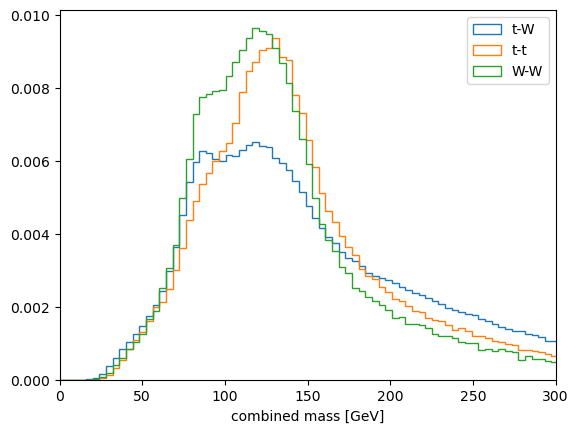

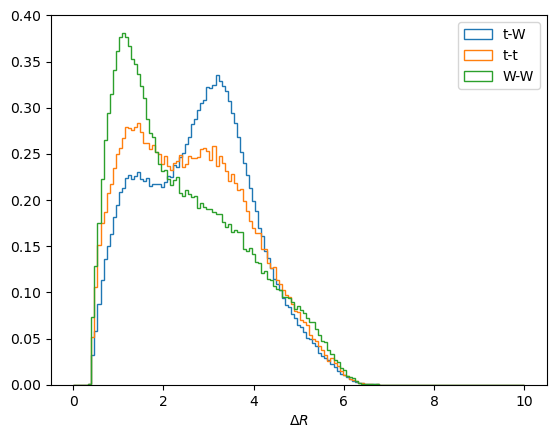

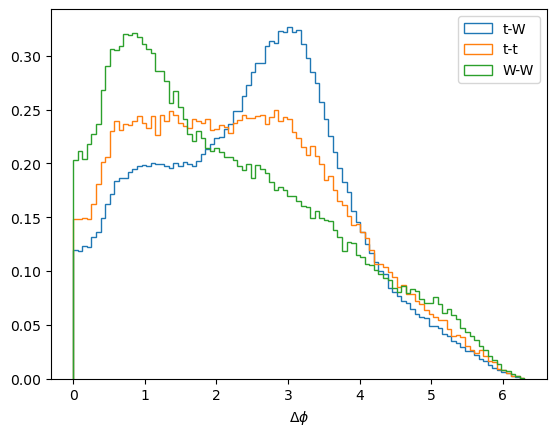

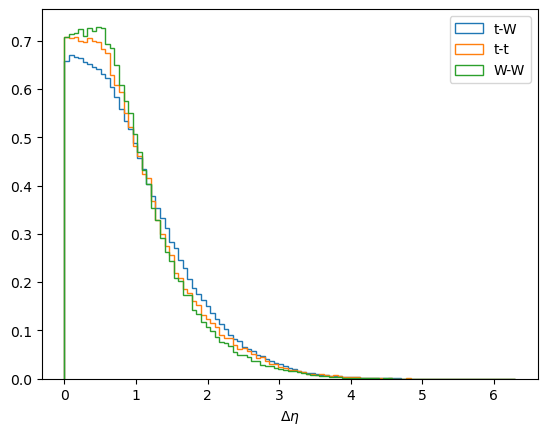

In [21]:
bins = np.linspace(0,800,200)
plt.hist(mass_tW,histtype='step',bins=bins,density=True)
plt.hist(mass_tt,histtype='step',bins=bins,density=True)
plt.hist(mass_WW,histtype='step',bins=bins,density=True)
plt.legend(["t-W", "t-t", "W-W"])
plt.xlabel("combined mass [GeV]")
plt.xlim([0,300])
plt.show()

bins = np.linspace(0,10,150)
plt.hist(deltar_tW,histtype='step',bins=bins,density=True)
plt.hist(deltar_tt,histtype='step',bins=bins,density=True)
plt.hist(deltar_WW,histtype='step',bins=bins,density=True)
plt.legend(["t-W", "t-t", "W-W"])
plt.xlabel("$\Delta R$")
plt.show()

bins = np.linspace(0,6.3,100)
plt.hist(deltaphi_tW,histtype='step',bins=bins,density=True)
plt.hist(deltaphi_tt,histtype='step',bins=bins,density=True)
plt.hist(deltaphi_WW,histtype='step',bins=bins,density=True)
plt.legend(["t-W", "t-t", "W-W"])
plt.xlabel("$\Delta \phi$")
plt.show()

bins = np.linspace(0,6.3,100)
plt.hist(deltaeta_tW,histtype='step',bins=bins,density=True)
plt.hist(deltaeta_tt,histtype='step',bins=bins,density=True)
plt.hist(deltaeta_WW,histtype='step',bins=bins,density=True)
plt.legend(["t-W", "t-t", "W-W"])
plt.xlabel("$\Delta \eta$")
plt.show()

In [22]:
features_flat = features.reshape((features.shape[0]*features.shape[1],features.shape[2]))
labels_flat = labels.reshape((labels.shape[0]*labels.shape[1]))

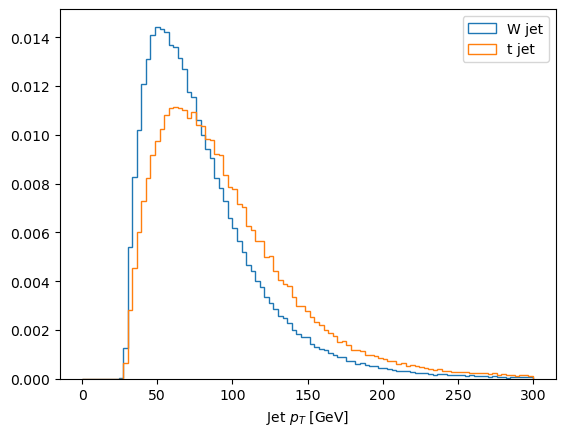

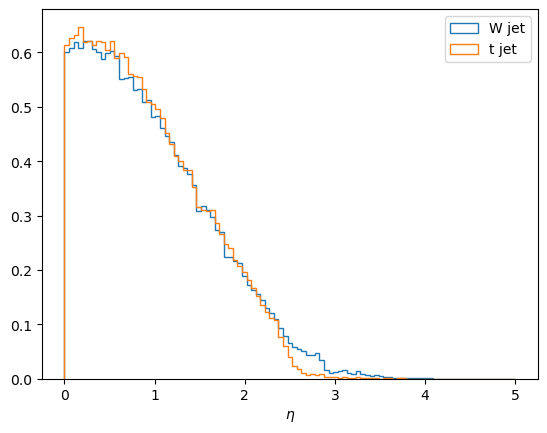

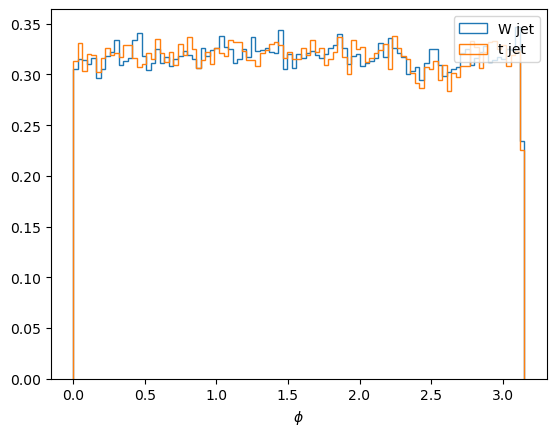

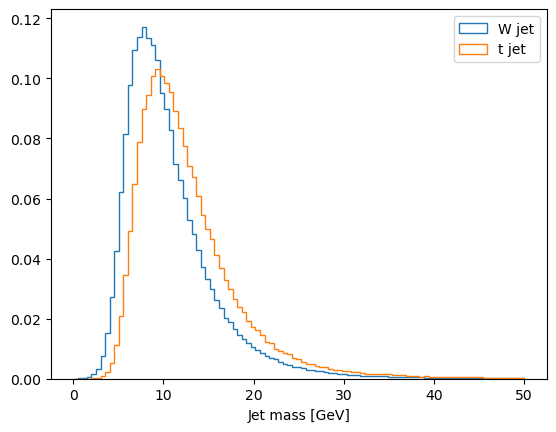

In [23]:
pt_wjet = features_flat[:,16][labels_flat==1]
pt_tjet = features_flat[:,16][labels_flat==0]

bins = np.linspace(0,300,100)
plt.hist(pt_wjet,histtype='step',bins=bins,density=True)
plt.hist(pt_tjet,histtype='step',bins=bins,density=True)
plt.legend(["W jet", "t jet"])
plt.xlabel("Jet $p_T$ [GeV]")
plt.show()

eta_wjet = features_flat[:,17][labels_flat==1]
eta_tjet = features_flat[:,17][labels_flat==0]

bins = np.linspace(0,5,100)
plt.hist(eta_wjet,histtype='step',bins=bins,density=True)
plt.hist(eta_tjet,histtype='step',bins=bins,density=True)
plt.legend(["W jet", "t jet"])
plt.xlabel("$\eta$")
plt.show()

phi_wjet = features_flat[:,18][labels_flat==1]
phi_tjet = features_flat[:,18][labels_flat==0]

bins = np.linspace(0,3.15,100)
plt.hist(phi_wjet,histtype='step',bins=bins,density=True)
plt.hist(phi_tjet,histtype='step',bins=bins,density=True)
plt.legend(["W jet", "t jet"])
plt.xlabel("$\phi$")
plt.show()

m_wjet = features_flat[:,19][labels_flat==1]
m_tjet = features_flat[:,19][labels_flat==0]

bins = np.linspace(0,50,100)
plt.hist(m_wjet,histtype='step',bins=bins,density=True)
plt.hist(m_tjet,histtype='step',bins=bins,density=True)
plt.legend(["W jet", "t jet"])
plt.xlabel("Jet mass [GeV]")
plt.show()

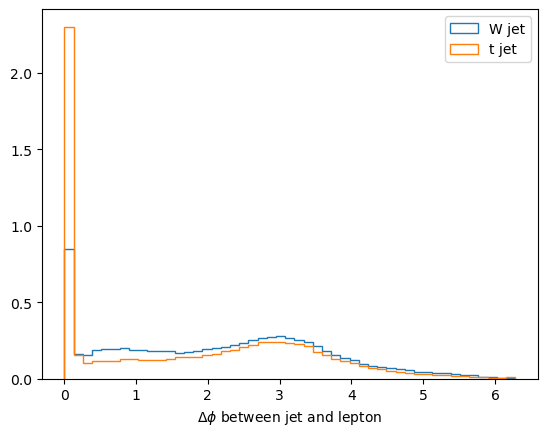

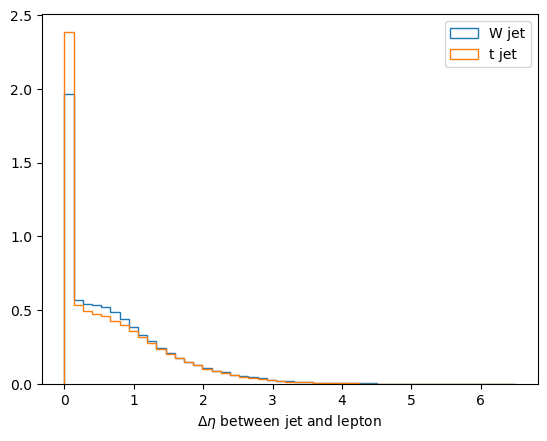

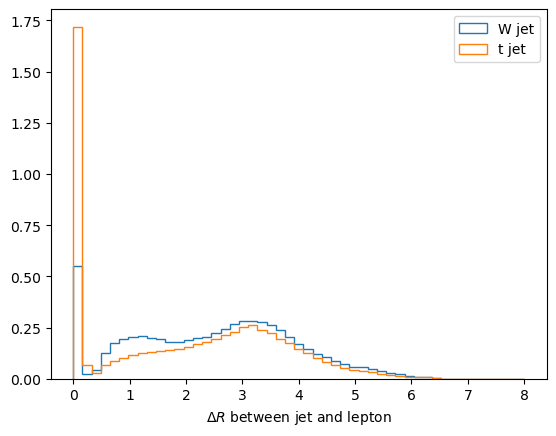

In [24]:
deltaphi_lepton_wjet = features_flat[:,20][labels_flat==1]
deltaphi_lepton_tjet = features_flat[:,20][labels_flat==0]

bins = np.linspace(0,2*np.pi,50)
plt.hist(deltaphi_lepton_wjet,histtype='step',bins=bins,density=True)
plt.hist(deltaphi_lepton_tjet,histtype='step',bins=bins,density=True)
plt.legend(["W jet", "t jet"])
plt.xlabel("$\Delta\phi$ between jet and lepton")
plt.show()

deltaeta_lepton_wjet = features_flat[:,21][labels_flat==1]
deltaeta_lepton_tjet = features_flat[:,21][labels_flat==0]

bins = np.linspace(0,6.5,50)
plt.hist(deltaeta_lepton_wjet,histtype='step',bins=bins,density=True)
plt.hist(deltaeta_lepton_tjet,histtype='step',bins=bins,density=True)
plt.legend(["W jet", "t jet"])
plt.xlabel("$\Delta\eta$ between jet and lepton")
plt.show()

deltar_lepton_wjet = features_flat[:,22][labels_flat==1]
deltar_lepton_tjet = features_flat[:,22][labels_flat==0]

bins = np.linspace(0,8,50)
plt.hist(deltar_lepton_wjet,histtype='step',bins=bins,density=True)
plt.hist(deltar_lepton_tjet,histtype='step',bins=bins,density=True)
plt.legend(["W jet", "t jet"])
plt.xlabel("$\Delta R$ between jet and lepton")
plt.show()

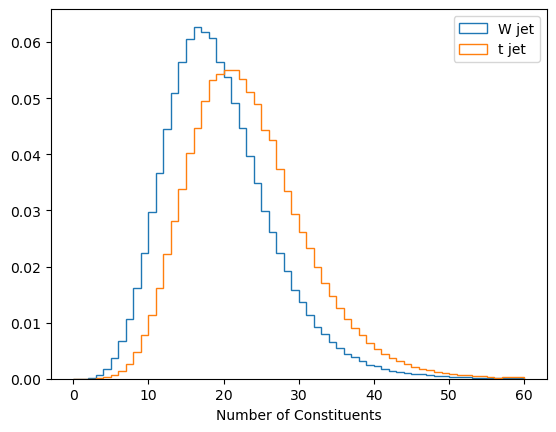

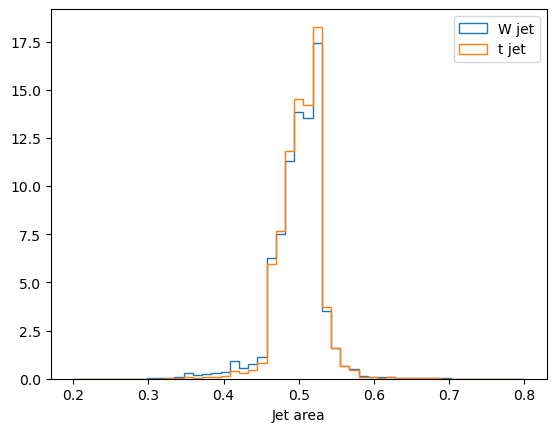

In [26]:
nconst_wjet = features_flat[:,23][labels_flat==1]
nconst_tjet = features_flat[:,23][labels_flat==0]

bins = np.linspace(0,60,60,dtype=int)
plt.hist(nconst_wjet,histtype='step',bins=bins,density=True)
plt.hist(nconst_tjet,histtype='step',bins=bins,density=True)
plt.legend(["W jet", "t jet"])
plt.xlabel("Number of Constituents")
plt.show()


area_wjet = features_flat[:,24][labels_flat==1]
area_tjet = features_flat[:,24][labels_flat==0]

bins = np.linspace(0.2,0.8,50)
plt.hist(area_wjet,histtype='step',bins=bins,density=True)
plt.hist(area_tjet,histtype='step',bins=bins,density=True)
plt.legend(["W jet", "t jet"])
plt.xlabel("Jet area")
plt.show()

In [ ]:
#defining dataset class
from torch.utils.data import Dataset, DataLoader
import torch

class dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.length

In [15]:
#defining the network
import torch
from torch import nn
from torch.nn import functional as F
class Net(nn.Module):
    def __init__(self,input_shape):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape,input_shape*2)
        self.fc2 = nn.Linear(input_shape*2,input_shape*4)
        self.fc3 = nn.Linear(input_shape*4,input_shape*2)
        self.fc4 = nn.Linear(input_shape*2,input_shape)
        self.fc5 = nn.Linear(input_shape,1)
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x

In [16]:
from torch.utils.data import random_split
from torch import Generator

data = dataset(features,labels)

train, validation = random_split(data, 
                                 [0.85, 0.15], # fractions for train, validation
                                 generator=torch.Generator().manual_seed(42))

In [17]:
trainloader = DataLoader(train,batch_size=64,shuffle=False)
valloader = DataLoader(validation,batch_size=len(validation),shuffle=False)

In [18]:
#hyper parameters
learning_rate = 0.005
epochs = 200
# Model , Optimizer, Loss
model = Net(input_shape=features.shape[2])
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss() # mean squared error loss function

In [ ]:
#forward loop
losses = []
accur = []
for i in range(epochs):
    model.train()
    for j,(x_train,y_train) in enumerate(trainloader):
    
        #calculate output
        output = model(x_train)
 
        #calculate loss
        loss = loss_fn(output,y_train.reshape(y_train.shape[0],y_train.shape[1],1))
 
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
    model.eval()
    for m,n in valloader:
        # print(model(m).shape)
        # print(model(m).reshape(-1).shape)
        # print(n.shape)
        n = n.reshape((n.shape[0],n.shape[1],1))
        pred = model(m).detach().numpy().round()
        # print(pred[0,:,:])
        # print(n[0,:,:])
        acc = np.mean(pred==np.array(n))

    losses.append(loss.item())
    accur.append(acc)
    print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

epoch 0	loss : 0.24090459942817688	 accuracy : 0.5965224204435873
epoch 1	loss : 0.24053983390331268	 accuracy : 0.6025192864030858
epoch 2	loss : 0.2386900633573532	 accuracy : 0.6080038572806171
epoch 3	loss : 0.2374894618988037	 accuracy : 0.6104146576663452
epoch 4	loss : 0.23597724735736847	 accuracy : 0.6125542430086789
epoch 5	loss : 0.2340877503156662	 accuracy : 0.6115296528447445
epoch 6	loss : 0.23270466923713684	 accuracy : 0.6116200578592093
epoch 7	loss : 0.23250849545001984	 accuracy : 0.6117707328833173
epoch 8	loss : 0.23172025382518768	 accuracy : 0.6127350530376084
epoch 9	loss : 0.23136143386363983	 accuracy : 0.6124337029893925
epoch 10	loss : 0.23117601871490479	 accuracy : 0.6133980231436837
epoch 11	loss : 0.2311241626739502	 accuracy : 0.6135185631629702
epoch 12	loss : 0.23157250881195068	 accuracy : 0.6145130183220829
epoch 13	loss : 0.2319806069135666	 accuracy : 0.6136089681774349
epoch 14	loss : 0.23180332779884338	 accuracy : 0.6152663934426229
epoch 15	l

In [ ]:
plt.plot(losses)